#   LangGraph 활용 - 상태 그래프 구현

---

## 환경 설정 및 준비

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import os
from glob import glob

from pprint import pprint
import json

`(3) langfuase handler 설정`

In [3]:
from langfuse.langchain  import CallbackHandler

# 콜백 핸들러 생성
langfuse_handler = CallbackHandler()

---

## **StateGraph**

- **StateGraph**는 상태 기반의 그래프 구조를 사용하여 **대화 흐름을 체계적으로 관리**

- 예제: **기본 챗봇 시스템**
    - 챗봇은 **StateGraph**를 통해 상태 기반 구조로 구현 (**노드**와 **엣지**로 구성)
    - 챗봇의 실행 흐름은 **START**에서 시작하여 **END**로 종료되며, 엣지를 통해 노드 간 전환을 처리

`(1) 상태(State)`

- **상태(State)** 는 그래프에서 처리하는 **데이터의 기본 구조**를 정의

- 각 상태는 다른 상태에 의해 **override(덮어쓰기)** 될 수 있어 데이터를 유연하게 관리할 수 있음 

- 상태 관리를 통해 **체계적인 데이터 처리**와 **흐름 제어**가 가능

In [4]:
from typing import TypedDict

# 상태 정의
class State(TypedDict):
    original_text: str   # 원본 텍스트
    summary: str         # 요약본
    final_summary: str   # 최종 요약본

- TypedDict를 사용하여 그래프의 상태를 정의
- 상태는 그래프 실행 중에 노드 간에 공유되는 데이터

`(2) 노드(Node)`

- **노드(Node)** 는 그래프 구조의 기본 구성 요소

- 노드는 **독립적인 작업 단위**로 특정 함수를 실행

- 각 노드는 다른 노드와 연결되어 **데이터 흐름**을 형성

- 상태를 입력으로 받아 처리하고 업데이트된 상태를 반환 

In [5]:
from langchain_openai import ChatOpenAI

# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# 요약 생성 노드
def generate_summary(state: State):
    """원본 텍스트를 요약하는 노드"""
    prompt = f"""다음 텍스트를 핵심 내용 중심으로 간단히 요약해주세요:

    [텍스트]
    {state['original_text']}

    [요약]
    """
    response = llm.invoke(prompt)
    
    return {"summary": response.content}

`(3) 그래프(Graph) 구성`

- **그래프(Graph)** 는 여러 노드들을 **엣지(Edge)**로 연결한 집합체

- 각 노드 간의 **연결 관계**가 전체 데이터 흐름을 결정

- 그래프는 빌드가 완료된 후 **실행 가능한 상태**가 됨 

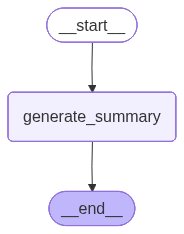

In [6]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# StateGraph 객체 생성 (Workflow)
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("generate_summary", generate_summary)

# 시작(START)과 끝(END) 엣지 추가 : 시작 -> generate_summary -> 끝
workflow.add_edge(START, "generate_summary")
workflow.add_edge("generate_summary", END)

# 그래프 컴파일
graph = workflow.compile()

# 그래프 시각화
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(graph.get_graph().draw_mermaid()) # Mermaid 다이어그램 텍스트로 출력

`(4) invoke 실행`

- **invoke** 방식은 그래프의 가장 **기본적인 실행 방법**으로, 단순하고 직관적인 처리를 제공

- 실행 결과는 모든 처리가 완료된 후 **최종 결과값**만 반환

- 전체 처리 과정이 완료될 때까지 **동기적으로 대기**하므로, 중간 상태를 확인할 수 없음 

- 간단한 처리나 최종 결과만 필요한 경우에 적합한 실행 방식

In [7]:
# 사용 예시
text = """
인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력, 
자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다. 
최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.
"""

initial_state = {
    "original_text": text,
}

final_state = graph.invoke(initial_state)

for key, value in final_state.items():
    print(f"{key}")
    print("-" * 50)
    pprint(f"{value}")
    print("=" * 100)

original_text
--------------------------------------------------
('\n'
 '인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력, \n'
 '자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다. \n'
 '최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.\n')
summary
--------------------------------------------------
('인공지능(AI)은 인간의 학습, 추론, 지각, 자연언어 이해 능력을 컴퓨터로 구현한 기술이며, 최근 기계학습과 딥러닝의 발전으로 다양한 '
 '분야에 활용되고 있다.')


`(5) 조건부 엣지(Edge)`

- **엣지**는 노드 간의 **연결 경로**를 정의하며, 챗봇의 대화 흐름을 구성하는 핵심 요소

- **조건부 엣지**를 통해 상황에 따라 다른 경로로 분기할 수 있어 **유연한 대화 구조**가 가능함 

- 사용자의 입력이나 상태에 따라 **동적으로 경로가 결정**되어 맥락에 맞는 응답을 제공

- 조건부 엣지를 활용하면 상황에 따른 적절한 대화 흐름을 구현할 수 있음 

In [8]:
from typing import Literal

# 요약 품질 체크 노드 (조건부 엣지와 함께 사용)
def check_summary_quality(state: State) -> Literal["needs_improvement", "good"]:
    """요약의 품질을 체크하고 개선이 필요한지 판단하는 노드"""
    prompt = f"""다음 요약의 품질을 평가해주세요. 
    요약이 명확하고 핵심을 잘 전달하면 'good'을, 
    개선이 필요하면 'needs_improvement'를 응답해주세요.
    
    요약본: {state['summary']}
    """
    response = llm.invoke(prompt).content.lower().strip()
    
    if "good" in response:
        print("---- Good Summary ----")
        return "good"
    else:
        print("---- Needs Improvement ----")
        return "needs_improvement"

# 요약 개선 노드 
def improve_summary(state: State):
    """요약을 개선하고 다듬는 노드"""
    prompt = f"""다음 요약을 더 명확하고 간결하게 개선해주세요:
    
    요약본: {state['summary']}
    """
    response = llm.invoke(prompt)
    
    return {"final_summary": response.content}

# 요약 완료 노드
def finalize_summary(state: State):
    """현재 요약을 최종 요약으로 설정하는 노드"""
    return {"final_summary": state["summary"]}

1. **워크플로우 구성**:
   - START → generate_summary → polish_summary → END 순서로 실행
   - generate_summary 결과에 따라 조건부 분기
   - 각 노드는 이전 노드의 출력을 입력으로 받아 처리

1. **체인 실행**:
   - 원본 텍스트를 초기 상태로 전달
   - 최종적으로 다듬어진 요약을 반환

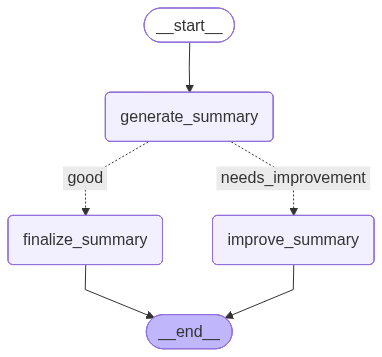

In [9]:
# 워크플로우 구성
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("generate_summary", generate_summary)
workflow.add_node("improve_summary", improve_summary)
workflow.add_node("finalize_summary", finalize_summary)

# 조건부 엣지 추가를 위한 라우팅 설정
workflow.add_conditional_edges(
    "generate_summary",
    check_summary_quality,
    {
        "needs_improvement": "improve_summary",
        "good": "finalize_summary"
    }
)

# 기본 엣지 추가
workflow.add_edge(START, "generate_summary")
workflow.add_edge("improve_summary", END)
workflow.add_edge("finalize_summary", END)

# 그래프 컴파일
graph = workflow.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

`(5) Stream 실행`

- **stream** 방식은 그래프 실행의 **중간 과정**을 실시간으로 확인할 수 있어 투명한 처리가 가능

- 각 노드의 실행 결과가 **순차적으로 스트리밍**되어 처리 흐름을 자세히 모니터링할 수 있음 

- 사용자에게 **진행 상황**을 즉각적으로 보여줄 수 있어 대화형 인터페이스에 적합

- 실시간 피드백이 필요한 복잡한 처리나 사용자 상호작용이 중요한 경우에 이상적인 실행 방식

- **stream_mode**: 스트리밍 실행 시 어떤 정보를 받을지 결정하는 중요한 옵션
   - 단순 진행상황 표시 → "values"
   - 디버깅/개발 → "updates"

In [10]:
# 1. "values" 모드 : 상태 값의 변경사항만 스트리밍
for chunk in graph.stream(initial_state, stream_mode="values"):
    print(chunk)
    print("=" * 100)

{'original_text': '\n인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력, \n자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다. \n최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.\n'}
---- Good Summary ----
{'original_text': '\n인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력, \n자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다. \n최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.\n', 'summary': '인공지능(AI)은 인간의 학습, 추론, 지각, 자연언어 이해 능력을 컴퓨터로 구현한 기술로, 기계학습과 딥러닝의 발전에 힘입어 다양한 분야에서 활용되고 있다.'}
{'original_text': '\n인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력, \n자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다. \n최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.\n', 'summary': '인공지능(AI)은 인간의 학습, 추론, 지각, 자연언어 이해 능력을 컴퓨터로 구현한 기술로, 기계학습과 딥러닝의 발전에 힘입어 다양한 분야에서 활용되고 있다.', 'final_summary': '인공지능(AI)은 인간의 학습, 추론, 지각, 자연언어 이해 능력을 컴퓨터로 구현한 기술로, 기계학습과 딥러닝의 발전에 힘입어 다양한 분야에서 활용되고 있다.'}


In [11]:
# 2. "updates" 모드 : 어떤 노드가 업데이트를 생성했는지 포함 (디버깅용)
for chunk in graph.stream(initial_state, stream_mode="updates"):
    print(chunk)
    print("=" * 100)

---- Good Summary ----
{'generate_summary': {'summary': '인공지능(AI)은 인간의 학습, 추론, 지각, 자연언어 이해 능력을 컴퓨터로 구현한 기술로, 최근 기계학습과 딥러닝의 발전으로 다양한 분야에 활용되고 있다.'}}
{'finalize_summary': {'final_summary': '인공지능(AI)은 인간의 학습, 추론, 지각, 자연언어 이해 능력을 컴퓨터로 구현한 기술로, 최근 기계학습과 딥러닝의 발전으로 다양한 분야에 활용되고 있다.'}}


---
# **[실습]**

- 사용자가 사용하는 언어를 감지하고, 한국어 질문이면 한국어 DB를 검색하고 영어 질문이면 영어 DB를 검색하는 라우팅 기능을 StateGraph로 구현합니다. 

- 리비안, 테슬라 데이터를 사용합니다. 


In [12]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

# OpenAI 임베딩 모델 생성
embeddings_openai = OpenAIEmbeddings(model="text-embedding-3-small")

# 한국어 문서로 저장되어 있는 벡터 저장소 로드
db_korean = Chroma(
    embedding_function=embeddings_openai,
    collection_name="db_korean_cosine_metadata",
    persist_directory="./chroma_db",
    )

print(f"한국어 문서 수: {db_korean._collection.count()}")

# 영어 문서를 저장하는 벡터 저장소 로드
db_english = Chroma(
    embedding_function=embeddings_openai,
    collection_name="eng_db_openai",
    persist_directory="./chroma_db",
    )

print(f"영어 문서 수: {db_english._collection.count()}")

한국어 문서 수: 39
영어 문서 수: 42


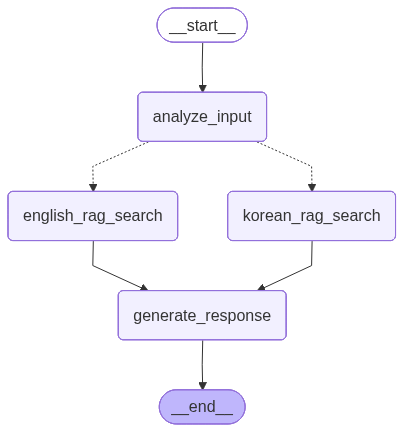

In [13]:
# 여기에 코드를 작성하세요.

from typing import List, TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import Image, display


# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# state 스키마 
class EelectricCarState(TypedDict):
    user_query: str
    is_korean: bool
    search_results: List[str]
    final_answer: str

def analyze_input(state: EelectricCarState) -> EelectricCarState:
    """ 사용자 입력이 한국어인지 판단하는 함수 """

    # 사용자 의도를 분석하기 위한 템플릿
    analyze_template = """
    사용자의 입력을 분석하여 한국어인지 판단하세요.

    사용자 입력: {user_query}

    한국어인 경우 "True", 아니면 "False"로 답변하세요.

    답변:
    """

    # 사용자 입력을 분석하여 한국어인지 판단
    analyze_prompt = ChatPromptTemplate.from_template(analyze_template)
    analyze_chain = analyze_prompt | llm | StrOutputParser()  # TODO: 프롬프트, LLM, 파서를 체인으로 연결
    result = analyze_chain.invoke({"user_query": state['user_query']})
    is_korean = result.strip().lower() == "true"  # TODO: result를 처리하여 boolean 값으로 변환
    
    # 결과를 상태에 업데이트 
    return {"is_korean": is_korean}


def korean_rag_search(state: EelectricCarState) -> EelectricCarState:
    """ 한국어 문서 검색 함수 """

    # 3개의 검색 결과를 가져옴
    results = db_korean.similarity_search(state['user_query'], k=3)  # TODO: 한국어 DB에서 유사도 검색 수행

    # 페이지 내용만 추출
    search_results = [doc.page_content for doc in results]  # TODO: results에서 page_content만 추출하여 리스트로 만들기

    # 검색 결과를 상태에 저장
    return {"search_results": search_results}


def english_rag_search(state: EelectricCarState) -> EelectricCarState:
    """ 영어 문서 검색 함수 """

    # 3개의 검색 결과를 가져옴
    results = db_english.similarity_search(state['user_query'], k=3)  # TODO: 영어 DB에서 유사도 검색 수행

    # 페이지 내용만 추출
    search_results = [doc.page_content for doc in results]  # TODO: results에서 page_content만 추출하여 리스트로 만들기

    # 검색 결과를 상태에 저장
    return {"search_results": search_results}


def generate_response(state: EelectricCarState) -> EelectricCarState:
    """ 답변 생성 함수 """

    # 답변 템플릿
    response_template = """
    사용자 입력: {user_query}
    검색 결과: {search_results}

    위 정보를 바탕으로 사용자의 질문에 대한 상세한 답변을 생성하세요. 
    검색 결과의 정보를 활용하여 정확하고 유용한 정보를 제공하세요.

    답변 (Answer in {language}):
    """

    # 답변 생성
    response_prompt = ChatPromptTemplate.from_template(response_template)
    response_chain = response_prompt | llm | StrOutputParser()  # TODO: 프롬프트, LLM, 파서를 체인으로 연결
    
    final_answer = response_chain.invoke(
        {
            "user_query": state['user_query'],   # TODO: 상태에서 user_query 가져오기
            "search_results": state['search_results'],  # TODO: 상태에서 search_results 가져오기
            "language": "한국어" if state['is_korean'] else "영어" # TODO: is_korean 값에 따라 "한국어" 또는 "영어" 설정
        }
    )
    
    # 결과를 상태에 저장
    return {"final_answer": final_answer}

def decide_next_step(
        state: EelectricCarState
    ) -> Literal["korean_rag_search", "english_rag_search"]:
    """ 다음 실행 단계를 결정하는 함수 """

    # 한국어인 경우 한국어 문서 검색 함수 실행
    if state['is_korean']:  # TODO: 한국어인지 확인하는 조건
        return "korean_rag_search"  
    
    # 영어인 경우 영어 문서 검색 함수 실행
    else:
        return "english_rag_search"
    
# 그래프 구성
builder = StateGraph(EelectricCarState)

# 노드 추가: 입력 분석, 한국어 문서 검색, 영어 문서 검색, 답변 생성
builder.add_node("analyze_input", analyze_input)  # TODO: analyze_input 함수 연결
builder.add_node("korean_rag_search", korean_rag_search)  # TODO: korean_rag_search 함수 연결
builder.add_node("english_rag_search", english_rag_search)  # TODO: english_rag_search 함수 연결
builder.add_node("generate_response", generate_response)  # TODO: generate_response 함수 연결

# 엣지 추가: 시작 -> 사용자 입력 분석 -> 조건부 엣지 -> 한국어 문서 검색 또는 영어 문서 검색 -> 답변 생성 -> 끝
builder.add_edge(START, "analyze_input")  # TODO: 시작 노드와 연결할 노드 이름

# 조건부 엣지 추가
builder.add_conditional_edges(
    "analyze_input",  # TODO: 조건부 엣지의 시작 노드
    decide_next_step   # TODO: 다음 단계를 결정하는 함수
)

builder.add_edge("korean_rag_search", "generate_response")  # TODO: 한국어 검색 후 다음 노드
builder.add_edge("english_rag_search", "generate_response")  # TODO: 영어 검색 후 다음 노드
builder.add_edge("generate_response", END)   # TODO: 최종 노드와 END 연결

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

<details>
<summary>💡 정답 보기</summary>

```python

from typing import List, TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import Image, display


# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# state 스키마 
class EelectricCarState(TypedDict):
    user_query: str
    is_korean: bool
    search_results: List[str]
    final_answer: str

def analyze_input(state: EelectricCarState) -> EelectricCarState:
    """ 사용자 입력이 한국어인지 판단하는 함수 """

    # 사용자 의도를 분석하기 위한 템플릿
    analyze_template = """
    사용자의 입력을 분석하여 한국어인지 판단하세요.

    사용자 입력: {user_query}

    한국어인 경우 "True", 아니면 "False"로 답변하세요.

    답변:
    """

    # 사용자 입력을 분석하여 한국어인지 판단
    analyze_prompt = ChatPromptTemplate.from_template(analyze_template)
    analyze_chain = analyze_prompt | llm | StrOutputParser()
    result = analyze_chain.invoke({"user_query": state['user_query']})
    is_korean = result.strip().lower() == "true"
    
    # 결과를 상태에 업데이트 
    return {"is_korean": is_korean}


def korean_rag_search(state: EelectricCarState) -> EelectricCarState:
    """ 한국어 문서 검색 함수 """

    # 3개의 검색 결과를 가져옴
    results = db_korean.similarity_search(state['user_query'], k=3)

    # 페이지 내용만 추출
    search_results = [doc.page_content for doc in results]

    # 검색 결과를 상태에 저장
    return {"search_results": search_results}


def english_rag_search(state: EelectricCarState) -> EelectricCarState:
    """ 영어 문서 검색 함수 """

    # 3개의 검색 결과를 가져옴
    results = db_english.similarity_search(state['user_query'], k=3)

    # 페이지 내용만 추출
    search_results = [doc.page_content for doc in results]

    # 검색 결과를 상태에 저장
    return {"search_results": search_results}


def generate_response(state: EelectricCarState) -> EelectricCarState:
    """ 답변 생성 함수 """

    # 답변 템플릿
    response_template = """
    사용자 입력: {user_query}
    검색 결과: {search_results}

    위 정보를 바탕으로 사용자의 질문에 대한 상세한 답변을 생성하세요. 
    검색 결과의 정보를 활용하여 정확하고 유용한 정보를 제공하세요.

    답변 (Answer in {language}):
    """

    # 답변 생성
    response_prompt = ChatPromptTemplate.from_template(response_template)
    response_chain = response_prompt | llm | StrOutputParser()
    
    final_answer = response_chain.invoke(
        {
            "user_query": state['user_query'],   # 사용자 입력 (상태에서 가져옴)
            "search_results": state['search_results'],  # 검색 결과 (상태에서 가져옴)
            "language": "한국어" if state['is_korean'] else "영어" # 언어 정보
        }
    )
    
    # 결과를 상태에 저장
    return {"final_answer": final_answer}

def decide_next_step(
        state: EelectricCarState
    ) -> Literal["korean_rag_search", "english_rag_search"]:
    """ 다음 실행 단계를 결정하는 함수 """

    # 한국어인 경우 한국어 문서 검색 함수 실행
    if state['is_korean']:
        return "korean_rag_search"  
    
    # 영어인 경우 영어 문서 검색 함수 실행
    else:
        return "english_rag_search"
    
# 그래프 구성
builder = StateGraph(EelectricCarState)

# 노드 추가: 입력 분석, 한국어 문서 검색, 영어 문서 검색, 답변 생성
builder.add_node("analyze_input", analyze_input)
builder.add_node("korean_rag_search", korean_rag_search)
builder.add_node("english_rag_search", english_rag_search)
builder.add_node("generate_response", generate_response)

# 엣지 추가: 시작 -> 사용자 입력 분석 -> 조건부 엣지 -> 한국어 문서 검색 또는 영어 문서 검색 -> 답변 생성 -> 끝
builder.add_edge(START, "analyze_input")

# 조건부 엣지 추가
builder.add_conditional_edges(
    "analyze_input",
    decide_next_step
)

builder.add_edge("korean_rag_search", "generate_response")
builder.add_edge("english_rag_search", "generate_response")
builder.add_edge("generate_response", END)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

```
</details>


In [14]:
# 그래프 실행을 위한 상태 초기화 (한국어 질문)
initial_state = {'user_query':'테슬라의 창업자는 누구인가요?'}

# 그래프 실행
result = graph.invoke(initial_state)

# 결과 출력
print("\n=== 결과 ===")
print("사용자 입력:", initial_state['user_query'])
print("답변:", result['final_answer'])



=== 결과 ===
사용자 입력: 테슬라의 창업자는 누구인가요?
답변: 테슬라(Tesla Motors, Inc.)의 창업자는 Martin Eberhard와 Marc Tarpenning입니다. 이들은 2003년 7월 1일에 회사를 설립했으며, 각각 초대 CEO와 CFO를 역임했습니다. 이후 Ian Wright가 합류했고, 2004년 2월에는 Elon Musk가 초기 자금 조달(시리즈 A)을 주도하며 투자자이자 회장 겸 최대 주주가 되었습니다. 또한, J. B. Straubel도 2004년에 CTO로 합류하여 총 다섯 명이 테슬라의 공동 창립자로 인정받고 있습니다.

요약하자면, 테슬라는 Martin Eberhard와 Marc Tarpenning이 처음 설립했으며, Elon Musk는 주요 투자자 및 경영진으로서 중요한 역할을 수행해왔습니다.


In [15]:
# 그래프 실행을 위한 상태 초기화 (영어 질문)
initial_state = {'user_query':'Who is the founder of Tesla?'}
result = graph.invoke(initial_state)

# 결과 출력
print("\n=== 결과 ===")
print("사용자 입력:", initial_state['user_query'])
print("답변:", result['final_answer'])


=== 결과 ===
사용자 입력: Who is the founder of Tesla?
답변: Tesla, Inc. was founded in July 2003 by Martin Eberhard and Marc Tarpenning, who served as CEO and CFO respectively. Ian Wright and J.B. Straubel also joined the company early on, and Elon Musk led Tesla's initial $7.5 million Series A funding round in 2004, becoming chairman and the largest shareholder. All five individuals—Martin Eberhard, Marc Tarpenning, Ian Wright, J.B. Straubel, and Elon Musk—are recognized as co-founders of Tesla.


---

## **Command**

- **Command 객체**는 LangGraph의 핵심 제어 도구로, 노드 함수의 **반환값**으로 사용

- 상태 관리와 흐름 제어를 **동시에 수행**할 수 있어 효율적인 그래프 운영이 가능

- 그래프의 **상태를 동적으로 업데이트**하면서 다음 실행할 노드를 지정할 수 있음 
    1.  **상태 업데이트:** 그래프의 상태(State)를 변경 (예: 새로운 정보를 추가하거나 기존 정보를 수정)
    2.  **제어 흐름:** 다음에 실행할 노드를 지정 가능 

### **StateGraph 수정**

1. `check_summary_quality` 함수를 제거하고 해당 로직을 `generate_summary` 노드에 통합

2. 각 노드가 `Command` 객체를 반환하도록 수정
   - `goto`: 다음에 실행할 노드 지정
   - `update`: 상태 업데이트 내용 지정

3. 조건부 엣지 대신 `Command`를 통한 라우팅을 사용
   - 품질 평가에 따라 `generate_summary`에서 `improve_summary` 또는 `finalize_summary`로 라우팅
   - `improve_summary`와 `finalize_summary`는 모두 END로 라우팅

4. 엣지 설정을 단순화
   - START에서 `generate_summary`로의 엣지만 명시적으로 정의
   - 나머지 라우팅은 `Command`를 통해 처리

In [16]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langchain_openai import ChatOpenAI

# 상태 정의
class State(TypedDict):
    original_text: str   # 원본 텍스트
    summary: str         # 요약본
    final_summary: str   # 최종 요약본

# LLM 인스턴스 생성
summary_llm = ChatOpenAI(model="gpt-4.1-mini")
eval_llm = ChatOpenAI(model="gpt-4.1")

# 요약 생성 노드
def generate_summary(state: State) -> Command[Literal["improve_summary", "finalize_summary"]]:
    """원본 텍스트를 요약하고 품질을 평가하는 노드"""
    # 요약 생성
    summary_prompt = f"""다음 텍스트를 핵심 내용 중심으로 간단히 요약해주세요:

    [텍스트]
    {state['original_text']}

    [요약]
    """
    summary = summary_llm.invoke(summary_prompt).content

#     summary = """인공지능은 컴퓨터 과학의 한 분야이며 인간의 능력을 구현한 것인데 \
# 요즘에는 정말 다양한 분야에서 활용되고 있고 특히 기계학습이랑 딥러닝이 발전하면서 \
# 더욱 활용도가 높아지고 있다고 합니다"""  # 테스트용

    # 품질 평가
    eval_prompt = f"""다음 요약의 품질을 평가해주세요. 
    요약이 명확하고 핵심을 잘 전달하면 'good'을, 
    개선이 필요하면 'needs_improvement'를 응답해주세요.
    
    요약본: {summary}
    """
    quality = eval_llm.invoke(eval_prompt).content.lower().strip()
    
    # 상태 업데이트와 함께 다음 노드로 라우팅
    return Command(
        goto="finalize_summary" if "good" in quality else "improve_summary",
        update={"summary": summary}
    )

# 요약 개선 노드
def improve_summary(state: State) -> Command[Literal[END]]:
    """요약을 개선하고 다듬는 노드"""
    prompt = f"""다음 요약을 더 명확하고 간결하게 개선해주세요:
    
    [기존 요약]
    {state['summary']}

    [개선 요약]
    """
    improved_summary = llm.invoke(prompt).content
    
    # 상태 업데이트와 함께 다음 노드로 라우팅
    return Command(
        goto=END,
        update={"final_summary": improved_summary}
    )

# 최종 요약 설정 노드
def finalize_summary(state: State) -> Command[Literal[END]]:
    """현재 요약을 최종 요약으로 설정하는 노드"""

    # 상태 업데이트와 함께 다음 노드로 라우팅
    return Command(
        goto=END,
        update={"final_summary": state["summary"]}
    )


**`Command` vs. 조건부 엣지(Conditional Edges)**

- **Command**는 상태 업데이트와 노드 이동을 **동시에 처리**할 때 사용되며, 특히 정보 전달이 필요한 복잡한 전환에 적합

- **조건부 엣지**는 단순한 분기 처리에 사용되며, 상태 변경 없이 **조건에 따른 이동**만 수행

- 두 방식의 **선택 기준**은 상태 업데이트 필요 여부에 따라 결정

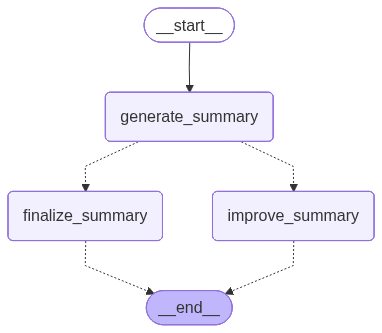

In [17]:
# 워크플로우 구성
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("generate_summary", generate_summary)
workflow.add_node("improve_summary", improve_summary)
workflow.add_node("finalize_summary", finalize_summary)

# 기본 엣지 추가
workflow.add_edge(START, "generate_summary")

# 그래프 컴파일
graph = workflow.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
# 그래프 실행 및 결과 확인
text = """
인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력,
자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다.
최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.
"""

initial_state = {
    "original_text": text,
}

for chunk in graph.stream(initial_state, stream_mode="values"):
    pprint(chunk)
    print("=" * 100)

{'original_text': '\n'
                  '인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력,\n'
                  '자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다.\n'
                  '최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.\n'}
{'original_text': '\n'
                  '인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력,\n'
                  '자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다.\n'
                  '최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.\n',
 'summary': '인공지능(AI)은 인간의 학습, 추론, 지각, 자연언어 이해 능력을 컴퓨터로 구현한 기술로, 최근 기계학습과 딥러닝의 '
            '발전으로 다양한 분야에서 활용되고 있다.'}
{'final_summary': '인공지능(AI)은 인간의 학습, 추론, 지각, 자연언어 이해 능력을 컴퓨터로 구현한 기술로, 최근 '
                  '기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.',
 'original_text': '\n'
                  '인공지능(AI)은 컴퓨터 과학의 한 분야로, 인간의 학습능력과 추론능력, 지각능력,\n'
                  '자연언어의 이해능력 등을 컴퓨터 프로그램으로 실현한 기술이다.\n'
                  '최근에는 기계학습과 딥러닝의 발전으로 다양한 분야에서 활용되고 있다.\n',
 'summary': '인공지능(AI)은 인간의 학습, 추론, 지각, 자연언어 이해 능력을 컴퓨터로 구현한 기술로, 최근 기계학습과 딥러닝의 '
            '발전으로 다양한 분야에서 활용되고 있다.'

---
# **[실습]**

- 사용자가 사용하는 언어를 감지하고, 한국어 질문이면 한국어 DB를 검색하고 영어 질문이면 영어 DB를 검색하는 라우팅 기능을 StateGraph로 구현합니다. 

- 리비안, 테슬라 데이터베이스를 사용합니다. 

- Command 구문을 사용합니다.


In [19]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

# OpenAI 임베딩 모델 생성
embeddings_openai = OpenAIEmbeddings(model="text-embedding-3-small")

# 한국어 문서로 저장되어 있는 벡터 저장소 로드
db_korean = Chroma(
    embedding_function=embeddings_openai,
    collection_name="db_korean_cosine_metadata",
    persist_directory="./chroma_db",
    )

print(f"한국어 문서 수: {db_korean._collection.count()}")

# 영어 문서를 저장하는 벡터 저장소 로드
db_english = Chroma(
    embedding_function=embeddings_openai,
    collection_name="eng_db_openai",
    persist_directory="./chroma_db",
    )

print(f"영어 문서 수: {db_english._collection.count()}")

한국어 문서 수: 39
영어 문서 수: 42


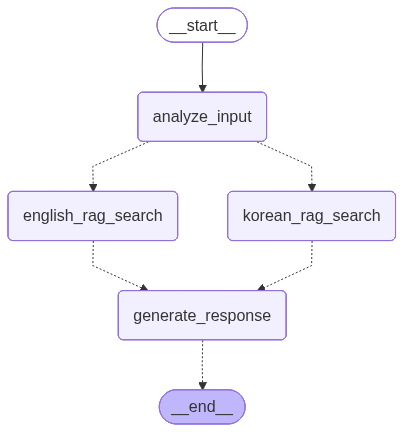

In [20]:
# 여기에 코드를 작성하세요.

from typing import List, TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.types import Command

# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# state 스키마 
class ElectricCarState(TypedDict):
    user_query: str
    is_korean: bool
    search_results: List[str]
    final_answer: str

def analyze_input(state: ElectricCarState) -> Command[Literal["korean_rag_search", "english_rag_search"]]:
    """ 사용자 입력이 한국어인지 판단하고 다음 단계를 Command로 지정하는 함수 """

    # 사용자 의도를 분석하기 위한 템플릿
    analyze_template = """
    사용자의 입력을 분석하여 한국어인지 판단하세요.

    사용자 입력: {user_query}

    한국어인 경우 "True", 아니면 "False"로 답변하세요.

    답변:
    """

    # 사용자 입력을 분석하여 한국어인지 판단
    analyze_prompt = ChatPromptTemplate.from_template(analyze_template)
    analyze_chain = analyze_prompt | llm | StrOutputParser()
    result = analyze_chain.invoke({"user_query": state['user_query']})
    is_korean = result.strip().lower() == "true"
    
    # Command를 사용하여 다음 노드와 상태 업데이트를 지정
    next_node = "korean_rag_search" if is_korean else "english_rag_search"
    
    return Command(
        goto=next_node,  # 다음에 실행할 노드 지정
        update={"is_korean": is_korean}  # 상태 업데이트
    )


def korean_rag_search(state: ElectricCarState) -> Command[Literal["generate_response"]]:
    """ 한국어 문서 검색 함수 """

    # 3개의 검색 결과를 가져옴
    results = db_korean.similarity_search(state['user_query'], k=3)

    # 페이지 내용만 추출
    search_results = [doc.page_content for doc in results]
    
    # Command를 사용하여 다음 노드와 상태 업데이트를 지정
    return Command(
        goto="generate_response",  # 항상 generate_response로 이동
        update={"search_results": search_results}  # 검색 결과 업데이트
    )


def english_rag_search(state: ElectricCarState) -> Command[Literal["generate_response"]]:
    """ 영어 문서 검색 함수 """

    # 3개의 검색 결과를 가져옴
    results = db_english.similarity_search(state['user_query'], k=3)

    # 페이지 내용만 추출
    search_results = [doc.page_content for doc in results]
    
    # Command를 사용하여 다음 노드와 상태 업데이트를 지정
    return Command(
        goto="generate_response",  # 항상 generate_response로 이동
        update={"search_results": search_results}  # 검색 결과 업데이트
    )

def generate_response(state: ElectricCarState) -> Command[Literal[END]]:
    """ 답변 생성 함수 """

    # 답변 템플릿
    response_template = """
    사용자 입력: {user_query}
    검색 결과: {search_results}

    위 정보를 바탕으로 사용자의 질문에 대한 상세한 답변을 생성하세요. 
    검색 결과의 정보를 활용하여 정확하고 유용한 정보를 제공하세요.

    답변 (Answer in {language}):
    """

    # 답변 생성
    response_prompt = ChatPromptTemplate.from_template(response_template)
    response_chain = response_prompt | llm | StrOutputParser()
    
    final_answer = response_chain.invoke(
        {
            "user_query": state['user_query'],
            "search_results": state['search_results'],
            "language": "한국어" if state['is_korean'] else "영어"
        }
    )
    
    # Command를 사용하여 END로 이동하고 최종 답변 업데이트
    return Command(
        goto=END,  # 그래프 실행 종료
        update={"final_answer": final_answer}  # 최종 답변 저장
    )
    
# 그래프 구성
builder = StateGraph(ElectricCarState)

# 노드 추가: 입력 분석, 한국어 문서 검색, 영어 문서 검색, 답변 생성
builder.add_node("analyze_input", analyze_input)
builder.add_node("korean_rag_search", korean_rag_search)
builder.add_node("english_rag_search", english_rag_search)
builder.add_node("generate_response", generate_response)

# 엣지 추가: 시작 -> 사용자 입력 분석
builder.add_edge(START, "analyze_input")

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

<details>
<summary>💡 정답 보기</summary>

```python
from typing import List, TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.types import Command

# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# state 스키마 
class ElectricCarState(TypedDict):
    user_query: str
    is_korean: bool
    search_results: List[str]
    final_answer: str

def analyze_input(state: ElectricCarState) -> Command[Literal["korean_rag_search", "english_rag_search"]]:
    """ 사용자 입력이 한국어인지 판단하고 다음 단계를 Command로 지정하는 함수 """

    # 사용자 의도를 분석하기 위한 템플릿
    analyze_template = """
    사용자의 입력을 분석하여 한국어인지 판단하세요.

    사용자 입력: {user_query}

    한국어인 경우 "True", 아니면 "False"로 답변하세요.

    답변:
    """

    # 사용자 입력을 분석하여 한국어인지 판단
    analyze_prompt = ChatPromptTemplate.from_template(analyze_template)
    analyze_chain = analyze_prompt | llm | StrOutputParser()
    result = analyze_chain.invoke({"user_query": state['user_query']})
    is_korean = result.strip().lower() == "true"
    
    # Command를 사용하여 다음 노드와 상태 업데이트를 지정
    next_node = "korean_rag_search" if is_korean else "english_rag_search"
    
    return Command(
        goto=next_node,  # 다음에 실행할 노드 지정
        update={"is_korean": is_korean}  # 상태 업데이트
    )


def korean_rag_search(state: ElectricCarState) -> Command[Literal["generate_response"]]:
    """ 한국어 문서 검색 함수 """

    # 3개의 검색 결과를 가져옴
    results = db_korean.similarity_search(state['user_query'], k=3)

    # 페이지 내용만 추출
    search_results = [doc.page_content for doc in results]
    
    # Command를 사용하여 다음 노드와 상태 업데이트를 지정
    return Command(
        goto="generate_response",  # 항상 generate_response로 이동
        update={"search_results": search_results}  # 검색 결과 업데이트
    )


def english_rag_search(state: ElectricCarState) -> Command[Literal["generate_response"]]:
    """ 영어 문서 검색 함수 """

    # 3개의 검색 결과를 가져옴
    results = db_english.similarity_search(state['user_query'], k=3)

    # 페이지 내용만 추출
    search_results = [doc.page_content for doc in results]
    
    # Command를 사용하여 다음 노드와 상태 업데이트를 지정
    return Command(
        goto="generate_response",  # 항상 generate_response로 이동
        update={"search_results": search_results}  # 검색 결과 업데이트
    )

def generate_response(state: ElectricCarState) -> Command[Literal[END]]:
    """ 답변 생성 함수 """

    # 답변 템플릿
    response_template = """
    사용자 입력: {user_query}
    검색 결과: {search_results}

    위 정보를 바탕으로 사용자의 질문에 대한 상세한 답변을 생성하세요. 
    검색 결과의 정보를 활용하여 정확하고 유용한 정보를 제공하세요.

    답변 (Answer in {language}):
    """

    # 답변 생성
    response_prompt = ChatPromptTemplate.from_template(response_template)
    response_chain = response_prompt | llm | StrOutputParser()
    
    final_answer = response_chain.invoke(
        {
            "user_query": state['user_query'],
            "search_results": state['search_results'],
            "language": "한국어" if state['is_korean'] else "영어"
        }
    )
    
    # Command를 사용하여 END로 이동하고 최종 답변 업데이트
    return Command(
        goto=END,  # 그래프 실행 종료
        update={"final_answer": final_answer}  # 최종 답변 저장
    )
    
# 그래프 구성
builder = StateGraph(ElectricCarState)

# 노드 추가: 입력 분석, 한국어 문서 검색, 영어 문서 검색, 답변 생성
builder.add_node("analyze_input", analyze_input)
builder.add_node("korean_rag_search", korean_rag_search)
builder.add_node("english_rag_search", english_rag_search)
builder.add_node("generate_response", generate_response)

# 엣지 추가: 시작 -> 사용자 입력 분석
builder.add_edge(START, "analyze_input")

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

```
</details>


In [21]:
# 그래프 실행을 위한 상태 초기화 (한국어 질문)
initial_state = {'user_query':'테슬라의 창업자는 누구인가요?'}

# 그래프 실행
result = graph.invoke(initial_state)

# 결과 출력
print("\n=== 결과 ===")
print("사용자 입력:", initial_state['user_query'])
print("답변:", result['final_answer'])


=== 결과 ===
사용자 입력: 테슬라의 창업자는 누구인가요?
답변: 테슬라(Tesla Motors, Inc.)의 창업자는 Martin Eberhard와 Marc Tarpenning입니다. 이들은 2003년 7월 1일에 회사를 설립했으며, 각각 처음에는 CEO와 CFO를 맡았습니다. 이후 Ian Wright도 초기 멤버로 합류했고, 2004년에는 Elon Musk가 750만 달러의 시리즈 A 자금 조달을 주도하며 회장 겸 최대 주주가 되었습니다. J.B. Straubel도 2004년에 CTO로 합류하여 초기 성장에 기여했습니다. 이 다섯 명 모두를 테슬라의 공동 설립자로 인정하고 있습니다. Elon Musk는 창업 초기부터는 아니지만, 이후 중요한 리더십 역할을 맡아 회사를 이끌어 왔습니다.


In [22]:
# 그래프 실행을 위한 상태 초기화 (영어 질문)
initial_state = {'user_query':'Who is the founder of Tesla?'}
result = graph.invoke(initial_state)

# 결과 출력
print("\n=== 결과 ===")
print("사용자 입력:", initial_state['user_query'])
print("답변:", result['final_answer'])


=== 결과 ===
사용자 입력: Who is the founder of Tesla?
답변: Tesla, Inc. was founded in July 2003 by Martin Eberhard and Marc Tarpenning, who served as CEO and CFO, respectively. Ian Wright joined the company shortly after its founding. In February 2004, Elon Musk led a $7.5 million Series A funding round, becoming chairman and the largest shareholder, and he later became CEO in 2008. Additionally, J.B. Straubel joined as CTO in May 2004. All five individuals—Martin Eberhard, Marc Tarpenning, Ian Wright, Elon Musk, and J.B. Straubel—are recognized as co-founders of Tesla.


---

## **[참고] LangGraph Studio**

- **LangGraph**는 다중 에이전트 워크플로우를 구축할 수 있는 플랫폼임
- **로컬 개발 환경 설정부터 Studio를 통한 테스트**까지의 전체 과정을 포괄하는 가이드를 제공함
- **LangGraph Studio**는 **다중 에이전트 시스템**을 효율적으로 개발하고 관리할 수 있는 도구임

`(1) 설치 및 설정`

- **필수 요구사항**
    - **Python 3.11 이상**
    - **LangSmith API 키** (무료 가입 가능)

-  **LangGraph CLI 설치**

    ```bash
    # Python 서버용 CLI 설치
    pip install --upgrade "langgraph-cli[inmem]"

    # uv 환경에서 설치
    uv add "langgraph-cli[inmem]"
    ```

-  **langgraph.json 파일(프로젝트 폴더)**
    ```json
    {
    "dependencies": ["."],
    "graphs": {
        "main_agent": "./src/graph.py:graph"
    }
    }
    ```

`(2) 개발 서버 실행`

- 프로젝트 루트 디렉토리에서 실행

    ```bash
    # 기본 실행
    (uv run) langgraph dev

    # 디버깅 모드 (선택적)
    (uv run) langgraph dev --debug-port 5678

    # Safari 사용자의 경우
    (uv run) langgraph dev --tunnel
    ```

`(3) LangGraph Studio 접속`


- **방법 1: 직접 URL 접속**
    ```
    https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
    ```

- **방법 2: LangSmith UI를 통한 접속**
    1. https://smith.langchain.com 로그인
    2. "LangGraph Platform Deployments" 탭 이동
    3. "LangGraph Studio" 버튼 클릭
    4. `http://127.0.0.1:2024` 입력 후 "Connect"